In [1]:
import numpy as np

#### one-hot hasing

In [2]:
samples =['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

어휘 사전에 있는 고유한 토큰의 수가 너무 커서 모두 다르기 어려울 때 사용

#### Embedding

In [3]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

Using TensorFlow backend.


In [4]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [5]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [6]:
x_train.shape

(25000, 20)

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________



Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 1s 52us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 0s 24us/step - loss: 0.5657 - acc: 0.7427 - val_loss

#### tokenize

In [8]:
import pandas as pd

imdb = pd.read_csv("imdb.csv")
texts=list(imdb["text"])
labels=list(imdb["label"])

In [23]:
# texts

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 20000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("%s개의 고유한 토큰을 찾았습니다." % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

178938개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (50000, 100)
레이블 텐서의 크기: (50000,)


In [11]:
x_train

array([[  50,   69,   24, ...,    5,  267,    8],
       [  10,   16, 1070, ...,    5,   25,  589],
       [4272,   34,    6, ..., 8219,    2,  383],
       ...,
       [  16, 1331, 8196, ...,  210,    3,   27],
       [  50, 1780,    4, ...,  141, 1511,  312],
       [2707,  254,    7, ...,    6, 6027,  495]])

* word2vec

In [12]:
from keras.preprocessing.text import text_to_word_sequence

for _ in range(len(texts)):
    texts[_]=text_to_word_sequence(texts[_])

In [24]:
# texts[0]

In [14]:
embedding_dim = 100

In [15]:
from gensim.models import Word2Vec
embedding_model = Word2Vec(texts, size=embedding_dim, sg=1)

In [25]:
# embedding_model.wv.vocab

In [17]:
embedding_model.wv.most_similar(positive=["movie"], topn=5)

[('film', 0.9305720925331116),
 ('filmbut', 0.8056830763816833),
 ('moviebut', 0.8034486770629883),
 ('movieit', 0.798157811164856),
 ('movieand', 0.7928781509399414)]

In [18]:
NUM_WORDS, EMB_DIM = embedding_model.wv.vectors.shape

* modeling

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Embedding(NUM_WORDS, EMB_DIM, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          4220100   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,540,165
Trainable params: 4,540,165
Non-trainable params: 0
_________________________________________________________________


* pre-trained word2vec embedding

In [20]:
model.layers[0].set_weights([embedding_model.wv.vectors])
model.layers[0].trainable=False

In [21]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('model.h5')

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.6980 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5038
Epoch 2/10
20000/20000 [==============================] - 2s 116us/step - loss: 0.6946 - acc: 0.5063 - val_loss: 0.6931 - val_acc: 0.5040
Epoch 3/10
20000/20000 [==============================] - 2s 118us/step - loss: 0.6884 - acc: 0.5433 - val_loss: 0.6742 - val_acc: 0.5839
Epoch 4/10
20000/20000 [==============================] - 2s 118us/step - loss: 0.6360 - acc: 0.6392 - val_loss: 0.6741 - val_acc: 0.5933
Epoch 5/10
20000/20000 [==============================] - 2s 116us/step - loss: 0.5689 - acc: 0.7061 - val_loss: 0.6875 - val_acc: 0.5973
Epoch 6/10
20000/20000 [==============================] - 2s 116us/step - loss: 0.5148 - acc: 0.7440 - val_loss: 0.7078 - val_acc: 0.6024
Epoch 7/10
20000/20000 [==============================] - 2s 116us/step - loss: 0.4635 - acc: 0.7791 - val_loss: 0.7160 - 

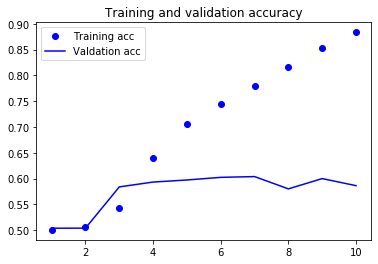

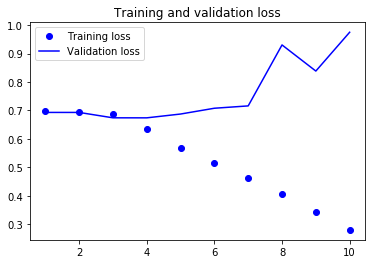

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Valdation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()